In [1]:
from geo_transform.tf_tps import ThinPlateSpline as tps
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from utils import tf_session
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


In [3]:
!ls

Untitled.ipynb	configs        logs	       tps_test.ipynb	     utils
__pycache__	data_loader    models	       train.py
checkpoints	etc	       sample_dataset  train_cnnalign.ipynb
cnngeo.h5	geo_transform  test.py	       train_cnngeo.ipynb


# 1.Data load

In [4]:
from data_loader.data_utils import tf_image_process
from data_loader import load_data
import random

In [5]:
_datapath = "../../datasets/PF-dataset-PASCAL/PF-dataset-PASCAL/JPEGImages"
filelist = os.listdir(_datapath)
random.shuffle(filelist)
input_size = (200, 200)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [6]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)
ds = tf.data.Dataset.from_tensor_slices(images).shuffle(2000)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(10)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


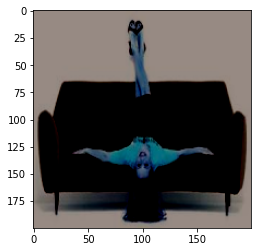

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


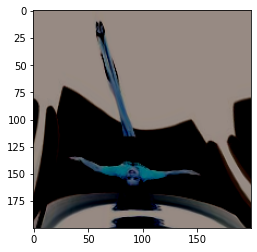

In [7]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)
plt.imshow(A[1]/255.)
plt.show()
plt.imshow(B[1]/255.)
plt.show()

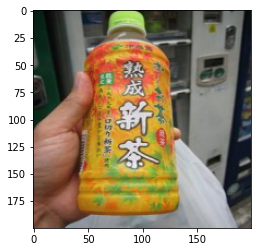

In [8]:
plt.imshow(images[1]/255)

# 2. Model definition

In [ ]:
from models.cnngeo import CNN_geotransform

In [ ]:
# (a) feature extraction

input_layer = tf.keras.Input(shape=(input_size[0], input_size[1],3))
normalized_input = tf.keras.applications.vgg16.preprocess_input(input_layer)
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
splited_model = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)
output = splited_model(normalized_input)
feature_extractor = tf.keras.Model(inputs=input_layer, outputs=output)

In [ ]:
cnngeo = CNN_geotransform(feature_extractor, 18)

In [ ]:
geo_parameters, correlations = cnngeo(A, B)

In [ ]:
cnngeo.summary()

In [ ]:
geo_parameters.shape

# 3.Training

In [ ]:
def loss_fn(preds, labels):
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    num_batch = preds.shape[0]
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), -preds, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), -labels, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    loss_mean = tf.reduce_mean(dist)
    return loss_mean


@tf.function
def train_step(image_A, image_B, labels, model, optimizer):
    with tf.GradientTape() as tape:
        preds, corr = model(image_A, image_B)
        loss = loss_fn(preds, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(100):
    for step, (image_a, image_b, labels) in enumerate(ds):
        t_loss = train_step(image_a, image_b, labels, cnngeo, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

In [ ]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds, corr = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

In [9]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


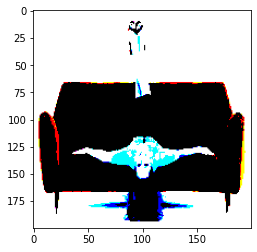

In [14]:
plt.imshow(A[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


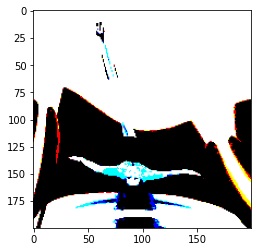

In [11]:
plt.imshow(B[1])

In [ ]:
plt.imshow(warping_images[4])

In [ ]:
plt.imshow(restore_original_image_from_array(B[1].numpy())/255)

In [ ]:
plt.imshow(restore_original_image_from_array(warping_images[1])/255)

In [ ]:
plt.imshow(images[1]/255)

# Comparison between ground-truth and prediction of motion vectors.

In [ ]:
print(p.shape)
print(preds.shape)

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds, corr = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

In [ ]:
def decode(x):
    x = (x + 1)/2
    if type(x) != np.ndarray:
        return x.numpy()
    else:
        return x
def makeBorder(image, bordersize):
    draw_image = image.copy()
    color = [1, 1, 1]
    draw_image = cv2.copyMakeBorder(draw_image,
                                    top=bordersize, bottom=bordersize,
                                    left=bordersize, right=bordersize,
                                    borderType=cv2.BORDER_CONSTANT,
                                    value=color)
    return draw_image


def draw_point(image, bordersize, points=None):
    draw_image = image.copy()
    H, W, C = draw_image.shape
    if points is None:
        points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    points = points * (W - 2 * bordersize, H - 2 * bordersize)
    points = points.astype(np.int32)
    for pnt in points:
        draw_image = cv2.circle(draw_image, tuple(
            pnt + bordersize), 1, (0, 1, 0), -1)
    return draw_image


def draw_arrow(image, bordersize, motion_parameters, src_points=None):
    draw_image = image.copy()
    H, W, C = image.shape
    if src_points is None:
        src_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    src_points = src_points * (W - 2 * bordersize, H - 2 * bordersize)
    src_points = src_points.astype(np.int32)
    motion_parameters = motion_parameters * \
        (W - 2 * bordersize, H - 2 * bordersize)
    dst_points = src_points + motion_parameters
    dst_points = dst_points.astype(np.int32)

    for src, dst in zip(src_points, dst_points):
        draw_image = cv2.arrowedLine(draw_image, tuple(src + bordersize), tuple(dst + bordersize),
                                     (1, 0, 0), 1)
    return draw_image

In [ ]:
motion_vector = p[0].numpy()

padd = 50
white_board = makeBorder(A[0].numpy(), padd)

In [ ]:
plt.imshow(draw_point(white_board, padd))

In [ ]:
plt.imshow(draw_arrow(white_board, padd, p[0].numpy()/2))

In [ ]:
plt.imshow(B[0].numpy())

In [ ]:
plt.imshow(draw_arrow(white_board, padd, preds[0].numpy()/2))

In [ ]:
plt.imshow(warping_images[0])

In [ ]:
cnngeo.save_weights("cnngeo.h5")